In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow as tf

%load_ext autoreload
%autoreload 2
from base import datahandler, prediction_models, evaluation, utils


2024-01-15 15:13:40.856806: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 15:13:40.856878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-15 15:13:40.921529: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-15 15:13:41.044052: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-15 15:13:42.339416: W tensorflow/compiler/tf2

In [2]:
# model_ew = tf.keras.models.load_model('/home/david/Code/splid-challenge/wandb/run-20240112_140537-85ahbucq/files\model_85ahbucq.hdf5')
# model_ew.save('models/ew_localizer.hdf5')


In [3]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1/')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir)

some_dataframes = {df_k : split_dataframes[df_k] for df_k in list(split_dataframes.keys())[:40]}

In [6]:
input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)',
       'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']

input_features_reduced = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)']

ew_input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Argument of Periapsis (deg)', 'Longitude (deg)', 'Altitude (m)']
ns_input_features = ['Eccentricity', 'Semimajor Axis (m)', 'RAAN (deg)', 'Inclination (deg)', 'Latitude (deg)', 'Altitude (m)']


utils.set_random_seed(42)
ds_gen_ew = datahandler.DatasetGenerator(split_df=split_dataframes, input_features=ew_input_features,
                                      with_labels=True, pad_location_labels=3,
                                      train_val_split=0.8, input_stride=1, padding='none',
                                      transform_features=True,
                                      input_history_steps=24, input_future_steps=24, seed=69)

# ds_gen_ns = datahandler.DatasetGenerator(split_df=split_dataframes, input_features=ns_input_features,
#                                       with_labels=True, pad_location_labels=2,
#                                       train_val_split=0.8, input_stride=4, padding='none',
#                                       transform_features=True,
#                                       input_history_steps=80, input_future_steps=80, seed=69)

=========================Creating Generator=======================
Seed: 69
nTrain: 200 nVal: 50 (0.80)
Padding: none
Scaling: True 
Horizons: 24-24 @ stride 1
Sin-Transformed features: ['Argument of Periapsis (deg)']
Padding node locations (3)
=========================Finished Generator=======================


(TensorSpec(shape=(None, 48, 5), dtype=tf.float64, name=None), {'EW_Node_Location': TensorSpec(shape=(None,), dtype=tf.int32, name=None)})
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 48, 5)]           0         
                                                                 
 flatten_2 (Flatten)         (None, 240)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               61696     
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 32)             

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


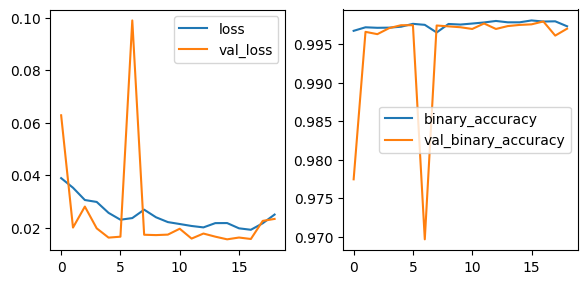

In [10]:
train_ew, val_ew = ds_gen_ew.get_datasets(512, label_features=['EW_Node_Location'], shuffle=True, stride=4)

print(train_ew.element_spec)

# TODO: make localizer its one class, with proper binary output so that different metrics can be evaluated live
#dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[[64,32],[32,16]], dense_layers=[64,32], l2_reg=0.0001, mixed_dropout=0.1, lr_scheduler=[30000,0.8], seed=0)
model_ew = prediction_models.Dense_NN(val_ew, conv1d_layers=[], dense_layers=[256,128,64,32], l2_reg=0.0, mixed_dropout=0.0, lr_scheduler=[], seed=0)
#dense_model = prediction_models.CNN(train_combined, conv_layers=[[64,6],[64,3],[64,3]], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[20000,0.8], seed=0)
#model_ew = prediction_models.LSTM_NN(val_ew, input_dropout=0.0, mixed_dropout=0.1, lstm_layers=[128,64], dense_layers=[32,16], l2_reg=0.0001, lr_scheduler=[], seed=1)

train_ew = train_ew.map(lambda x,y:(x,y['EW_Node_Location']))
val_ew = val_ew.map(lambda x,y:(x,y['EW_Node_Location'])) # temporary fix to allow class weights

model_ew.summary()
hist = model_ew.fit(train_ew, val_ds=val_ew, epochs=20, verbose=1, plot_hist=True, class_weight={0: 1.0, 1: 2.0}, callbacks=[])
#model_ew.model.save('models/ew_localizer.hdf5')

2024-01-13 17:41:51.916526: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:41:51.981327: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:41:51.981405: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:41:51.989899: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:41:51.989990: I external/local_xla/xla/stream_executor

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 40, 6)]           0         
                                                                 
 flatten (Flatten)           (None, 240)               0         
                                                                 
 dense (Dense)               (None, 256)               61696     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 NS_Node_Location (Dense)    (None, 1)                 33    

2024-01-13 17:41:58.673514: I external/local_xla/xla/service/service.cc:168] XLA service 0x171df9b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-13 17:41:58.673563: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-01-13 17:41:58.679053: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-13 17:41:59.236645: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1705164119.319279  105394 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


790/790 [==============================] - 14s 12ms/step - loss: 0.1008 - binary_accuracy: 0.9970 - precision: 0.0191 - recall: 0.0272 - val_loss: 0.0110 - val_binary_accuracy: 0.9990 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
790/790 [==============================] - 10s 12ms/step - loss: 0.0918 - binary_accuracy: 0.9976 - precision: 0.0750 - recall: 0.0777 - val_loss: 0.0098 - val_binary_accuracy: 0.9990 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
790/790 [==============================] - 11s 13ms/step - loss: 0.0891 - binary_accuracy: 0.9973 - precision: 0.0657 - recall: 0.0835 - val_loss: 0.0128 - val_binary_accuracy: 0.9990 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
790/790 [==============================] - 11s 14ms/step - loss: 0.0823 - binary_accuracy: 0.9975 - precision: 0.0821 - recall: 0.0932 - val_loss: 0.0123 - val_binary_accuracy: 0.9990 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
790/790 

/home/david/miniconda3/envs/splid-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/david/Code/splid-challenge/base/prediction_models.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


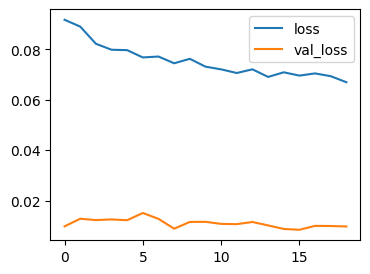

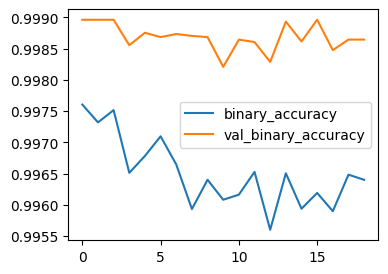

In [6]:
train_ns, val_ns = ds_gen_ns.get_datasets(512, label_features=['NS_Node_Location'], shuffle=True, stride=1)

model_ns = prediction_models.Dense_NN(train_ns, conv1d_layers=[], dense_layers=[256, 128,64,32], l2_reg=0.0, mixed_dropout=0.0, lr_scheduler=[], seed=0)
train_ns = train_ns.map(lambda x,y:(x,y['NS_Node_Location']))
val_ns = val_ns.map(lambda x,y:(x,y['NS_Node_Location'])) # temporary fix to allow class weights

model_ns.summary()
hist = model_ns.fit(train_ns, val_ds=val_ns, epochs=20, verbose=1, plot_hist=False, class_weight={0: 0.5, 1: 20.0}, callbacks=[])
model_ns.model.save('models/ns_localizer.hdf5')

model_ns.plot_hist(hist, [k for k in hist.history.keys() if 'loss' in k])
model_ns.plot_hist(hist, [k for k in hist.history.keys() if 'accuracy' in k])

In [ ]:
train_ds, val_ds = ds_gen_ew.get_datasets(512, label_features=['EW_Node_Location'],
                                               shuffle=True,
                                               stride=1)
print(train_ds.element_spec)

model = prediction_models.Dense_NN(val_ds, 
                                    conv1d_layers=[],
                                    dense_layers=config.model['dense_layers'],
                                    l2_reg=config.model['l2_reg'],
                                    input_dropout=config.model['input_dropout'],
                                    mixed_dropout=config.model['mixed_dropout'],
                                    lr_scheduler=config.model['lr_scheduler'],
                                    seed=0)
model.summary()

# train
hist = model.fit(train_ds, val_ds=val_ds,
                    epochs=25,
                    plot_hist=False,
                    class_weight={0: config.training['class_weight_0'], 1: config.training['class_weight_1']},
                    callbacks=[WandbMetricsLogger()],
                         verbose=2)

In [4]:
model_ew = tf.keras.models.load_model('/home/david/Code/splid-challenge/models/ew_localizer.hdf5')
#model_ew.save('models/ew_localizer.hdf5')



In [11]:
eval_df, evaluator, mergeDf = evaluation.evaluate_localizer(ds_gen_ew,
                                                            split_dataframes=split_dataframes,
                                                            gt_path=challenge_data_dir / 'train_labels.csv',
                                                            model=model_ew,
                                                            train=False,
                                                            with_initial_node=False,
                                                            remove_consecutives=True,
                                                            direction='EW',
                                                            return_scores=False)


3331/3331 - 8s - 8s/epoch - 2ms/step
Precision: 0.77
Recall: 0.22
F2: 0.25
RMSE: 3.082
TP: 10 FP: 3 FN: 36


In [21]:
print(eval_df.head(20))
print(mergeDf.head(20))

    ObjectID  TimeIndex  Location  Location_Pred Node Type Direction
0        103        206         1              1   SS   NK        EW
1        103        207         1              1   SS   NK        EW
2        103        208         1              1   AD   NK        EW
3        103        209         1              1   AD   NK        EW
4        103        210         1              0   AD   NK        EW
5        103        325         1              1   AD   NK        EW
6        103        326         1              1   AD   NK        EW
7        103        327         1              1   AD   NK        EW
8        103        328         1              1   AD   NK        EW
9        103        329         1              1   AD   NK        EW
10       103        340         1              0   AD   NK        EW
11       103        341         1              0   AD   NK        EW
12       103        342         1              0   IK   HK        EW
13       103        343         1 

['200', '189', '213', '128', '2', '13', '27', '247', '159', '83', '133', '40', '41', '7', '129', '209', '55', '99', '196', '14', '49', '95', '56', '12', '37', '191', '181', '32', '188', '23', '109', '29', '154', '183', '43', '132', '158', '25', '62', '92', '6', '96', '35', '225', '117', '94', '250', '142', '194', '219', '162', '145', '38', '166', '39', '75', '113', '18', '3', '168', '134', '118', '80', '111', '243', '57', '242', '172', '140', '179', '231', '124', '192', '174', '81', '249', '68', '70', '146', '163', '206', '89', '31', '203', '149', '195', '103', '232', '182', '64', '152', '141', '207', '108', '125', '126', '101', '151', '77', '186', '110', '16', '226', '169', '79', '59', '17', '138', '72', '180', '1', '144', '178', '246', '127', '46', '244', '130', '106', '90', '34', '175', '102', '22', '164', '112', '190', '65', '136', '156', '228', '85', '234', '217', '93', '143', '53', '131', '173', '177', '147', '150', '204', '20', '216', '155', '42', '197', '201', '135', '24', '237

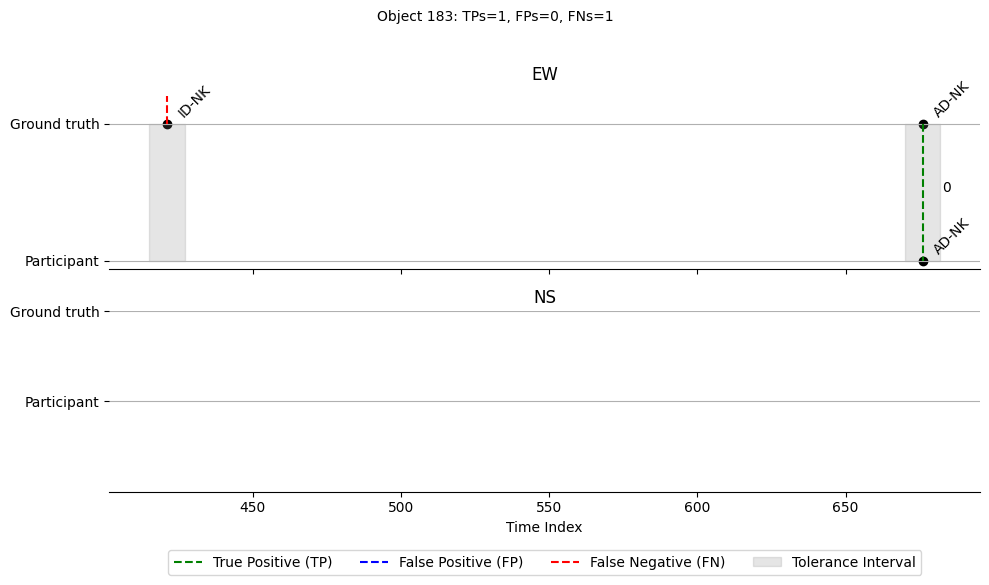

In [16]:
print(ds_gen_ew.train_keys)
evaluator.plot(183)

In [20]:

direction = 'EW'
ground_truth_from_file = pd.read_csv(labels_dir)
ground_truth_from_file = ground_truth_from_file[ground_truth_from_file['ObjectID'].isin([121,122,123])].copy()
ground_truth_from_file = ground_truth_from_file[(ground_truth_from_file['Direction'] == direction)]
ground_truth_from_file = ground_truth_from_file.sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)

mergeDf = ground_truth_from_file.copy()
mergeDf = mergeDf.drop([4])
mergeDf.loc[-1] = [121, 817, 'EW', 'IK', 'HK']  # adding a row
mergeDf.index = mergeDf.index + 1  # shifting index
mergeDf = mergeDf.sort_index()  # sorting by index
print(mergeDf)
print(ground_truth_from_file)

evaluator = evaluation.NodeDetectionEvaluator(ground_truth_from_file, mergeDf)
precision, recall, f2, rmse, total_tp, total_fp, total_fn = evaluator.score()
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F2: {f2:.2f}')
print(f'RMSE: {rmse:.4}')
print(f'TP: {total_tp} FP: {total_fp} FN: {total_fn}')

    ObjectID  TimeIndex Direction Node Type
0        121        817        EW   IK   HK
1        121          0        EW   SS   NK
2        121        124        EW   AD   NK
3        121        557        EW   AD   NK
4        121        783        EW   AD   NK
6        122          0        EW   SS   NK
7        122        124        EW   AD   NK
8        122        557        EW   AD   NK
9        122        783        EW   AD   NK
10       122        816        EW   IK   HK
11       123          0        EW   SS   NK
12       123        124        EW   AD   NK
13       123        557        EW   AD   NK
14       123       1804        EW   AD   NK
    ObjectID  TimeIndex Direction Node Type
0        121          0        EW   SS   NK
1        121        124        EW   AD   NK
2        121        557        EW   AD   NK
3        121        783        EW   AD   NK
4        121        816        EW   IK   HK
5        122          0        EW   SS   NK
6        122        124        E

In [ ]:
eval_df = evaluation.localization_eval(ds_gen, challenge_data_dir / 'train_labels.csv', dense_model.model, train=True, add_initial_node=True)

2024-01-06 23:47:48.838844: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1028534400 exceeds 10% of free system memory.


In [10]:
false_preds = eval_df.loc[(eval_df['Location'] != eval_df['Location_Pred'])].sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
print(false_preds.head(80))
false_preds = eval_df[eval_df['Location'] != eval_df['Location_Pred']]
print(len(false_preds))
print(len(eval_df))

    ObjectID  TimeIndex  Location  Location_Pred Node Type Direction
0        106         69         0              1   AD   NK        EW
1        108        179         0              1   SS   NK        EW
2        114        201         0              1   AD   NK        EW
3        116        201         0              1   AD   NK        EW
4        117        461         0              1   AD   NK        EW
5        123        125         0              1   AD   NK        EW
6        124        367         0              1   AD   NK        EW
7        129        972         1              0   IK   CK        EW
8        130         86         1              0   IK   CK        EW
9        131        155         0              1   AD   NK        EW
10       135        936         1              0   IK   CK        EW
11       139       1009         1              0   AD   NK        EW
12       139       1098         1              0   IK   CK        EW
13       141        157         1 